In [1]:
import pandas as pd
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt


/users/PCON0041/xiaohu/anaconda3/envs/t5chem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# similar reactions

In [2]:
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
import rdkit.Chem.QED as QED
import networkx as nx

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')   
df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/t5chem_results/uspto500mt/predictions_uspto.csv')
data = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/USPTO500MT_test_processed_100.csv')
print(df1.shape)
t5target = df1['target'].values / 100
t5pred = df1['prediction'].values / 100
ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/result.pt',map_location=torch.device('cpu'))[:,0])

(9497, 2)


In [3]:
def screen_matrix(matrix, threshold):
    n = len(matrix)
    for i in range(n):
        for j in range(n):
            if matrix[i][j] <= threshold:
                matrix[i][j] = 0

def find_index_pairs(matrix, threshold):
    index_pairs = []
    for i in range(len(matrix)):
        for j in range(i):
            if matrix[i][j] >= threshold:
                index_pairs.append((i, j))
    return index_pairs

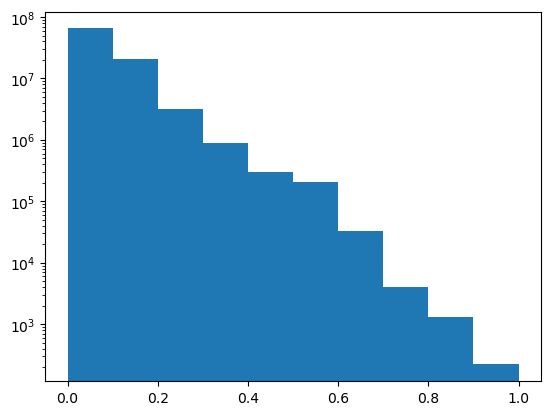

In [4]:
from rdkit import RDLogger
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
RDLogger.DisableLog('rdApp.*')

with open('reaction_similarity.npy', 'rb') as f:
    a = np.load(f)
b = a.flatten()
plt.hist(b)
plt.yscale('log')

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

threshold = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
total_len = []
our_better_len = []
t5_mae_list = []
our_mae_list = []
for thres in threshold:
    pairs = find_index_pairs(a, thres)
    print(len(pairs))

    df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/t5chem_results/uspto500mt/predictions_uspto.csv')
    data = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/USPTO500MT_test_processed_100.csv')
    t5target = df1['target'].values 
    t5pred = df1['prediction'].values 
    ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/result.pt',map_location=torch.device('cpu'))[:,0]) * 100

    target = []
    target_diff = []
    t5 = []
    t5_diff = []
    our = []
    our_diff = []
    r = []
    ra = []
    p = []

    sim = []

    for i in range(len(pairs)):
        r.append(data['reactants'].values[pairs[i][0]])
        r.append(data['reactants'].values[pairs[i][1]])
        ra.append(data['reagents'].values[pairs[i][0]])
        ra.append(data['reagents'].values[pairs[i][1]])
        p.append(data['products'].values[pairs[i][0]])
        p.append(data['products'].values[pairs[i][1]])
        target.append(data['yield'].values[pairs[i][0]])
        target.append(data['yield'].values[pairs[i][1]])
        t5.append(t5pred[pairs[i][0]])
        t5.append(t5pred[pairs[i][1]])
        our.append(ourpred[pairs[i][0]])
        our.append(ourpred[pairs[i][1]])
        target_diff.append(data['yield'].values[pairs[i][1]] - data['yield'].values[pairs[i][0]])
        t5_diff.append(t5pred[pairs[i][1]] - t5pred[pairs[i][0]])
        our_diff.append(ourpred[pairs[i][1]] - ourpred[pairs[i][0]])

        sim.append(a[pairs[i][0], pairs[i][1]])
        #print('=========================================')

    from scipy import stats
    print('===================')
    print(thres)
    print(len(target_diff))
    print(np.mean(abs(np.array(our) - np.array(target))))
    print(np.mean(abs(np.array(t5) - np.array(target))))

    our_mae_list.append(np.mean(abs(np.array(our) - np.array(target))))
    t5_mae_list.append(np.mean(abs(np.array(t5) - np.array(target))))
    total_len.append(len(target_diff))

    res_our = stats.pearsonr(target_diff, our_diff)
    print(res_our)
    res_t5 = stats.pearsonr(target_diff, t5_diff)
    print(res_t5)
    #res_our = stats.spearmanr(target_diff, our_diff)
    #print(res_our)
    #res_t5 = stats.spearmanr(target_diff, t5_diff)
    #print(res_t5)

    our_diff = np.array(our_diff)
    t5_diff = np.array(t5_diff)
    target_diff = np.array(target_diff)
    index = np.where(abs(target_diff - our_diff) < abs(target_diff - t5_diff))[0]
    index2 = np.where(abs(target_diff - our_diff) > abs(target_diff - t5_diff))[0]
    print(len(index),len(index2), len(index)/len(target_diff))

    our_better_len.append(len(index))

    

1526
0.8
1526
15.834066791396936
15.872841893782935
(0.17378837467882685, 8.17816924494281e-12)
(0.30886818231690444, 4.3453512189184285e-35)
813 713 0.5327653997378768
696
0.85
696
15.73620217161617
15.85895331022383
(0.1001816223297723, 0.00817202204857316)
(0.2648544690865273, 1.2297080951497866e-12)
373 323 0.5359195402298851
221
0.9
221
16.219039012080405
16.47459986199081
(0.08769612893455198, 0.1940100721077716)
(0.12107322740713349, 0.07244845598128545)
123 98 0.5565610859728507
156
0.91
156
16.399139624986894
16.054073726825226
(0.03185939036241555, 0.6929730700163855)
(0.13977257528295478, 0.08181130660631795)
86 70 0.5512820512820513
100
0.92
100
16.90934483242035
17.55354630279541
(-0.07732875275881806, 0.4444433895585063)
(-0.024031771728693387, 0.812400329554328)
63 37 0.63
67
0.93
67
17.0908532968208
17.58543260488937
(0.05088437166082668, 0.6825885359243372)
(0.04236555768842265, 0.7335523516722844)
40 27 0.5970149253731343
42
0.94
42
16.679862549191427
17.2591185978480

12
[15.872841893782935, 15.85895331022383, 16.47459986199081, 16.054073726825226, 17.55354630279541, 17.58543260488937, 17.259118597848072, 17.005654978752137, 17.506188801356725, 17.743297153049046, 15.517744178771972, 17.91520799001058]
[15.834066791396936, 15.73620217161617, 16.219039012080405, 16.399139624986894, 16.90934483242035, 17.0908532968208, 16.679862549191427, 15.040337085723877, 15.513672474452425, 15.972946039835612, 16.515723876953125, 21.310179138183592]
[1526, 696, 221, 156, 100, 67, 42, 24, 14, 9, 5, 3]
[0.5327654  0.53591954 0.55656109 0.55128205 0.63       0.59701493
 0.5952381  0.70833333 0.71428571 0.66666667 0.8        1.        ]


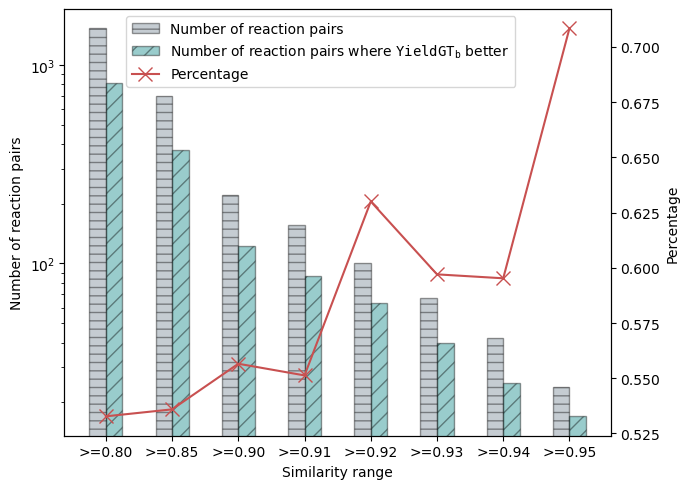

In [6]:
import matplotlib.pyplot as plt
our_color = '#008080'
t5_color = '#708090'
back_color = '#D9E4F1'
print(len(threshold))
x = np.arange(len(threshold[0:8]))
print(t5_mae_list)
print(our_mae_list)
print(total_len)
print(np.array(our_better_len/np.array(total_len)))
#plt.yscale('log')
fig, ax1 = plt.subplots(figsize=(7,5))
ax2 = ax1.twinx()
ax1.bar(x-0.125,total_len[0:8],width=0.25,label='Number of reaction pairs',color=t5_color, alpha=0.4,  edgecolor='black', hatch='--')
ax1.bar(x+0.125,our_better_len[0:8],width=0.25,label='Number of reaction pairs where $\mathtt{YieldGT_{b}}$ better',color=our_color, alpha=0.4, edgecolor='black', hatch='//')
ax1.set_yscale('log')
ax1.set_xlabel('Similarity range')
ax1.set_xticks(x, ['>=0.80', '>=0.85',  '>=0.90',  '>=0.91',  '>=0.92', '>=0.93',  '>=0.94', '>=0.95'], fontsize=10)
ax1.set_ylabel('Number of reaction pairs')
ax2.plot(x, np.array(our_better_len[0:8])/np.array(total_len[0:8]), marker='x', ms=10, linewidth=1.5, color='#C85050',label='Percentage')
#for i in range(len(x)):
#    ax2.text(x[i]-0.25, our_better_len[i]/total_len[i]+0.003, str(round(our_better_len[i]/total_len[i],3)), fontsize=10, color='r')
    #, weight="bold"
    #ax2.text(x[i]-0.5, our_better_len[i]/total_len[i]+0.01,  str('t5:' + str(round(t5_mae_list[i],2))), fontsize='x-small')
    #ax2.text(x[i]-0.5, our_better_len[i]/total_len[i]+0.02,  str('YieldGT:' + str(round(our_mae_list[i],2))), fontsize='x-small')
ax2.set_ylabel('Percentage')
#ax2.grid()
#ax2.legend()
#ax1.legend()s
# Get handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, 1), bbox_transform=ax1.transAxes, fontsize=10)

# Adjust layout to prevent legend from overlapping with the plot
plt.tight_layout()

plt.show()


In [56]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

threshold = [0.95]
total_len = []
our_better_len = []
t5_mae_list = []
our_mae_list = []
for thres in threshold:
    pairs = find_index_pairs(a, thres)
    print(len(pairs))

    df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/t5chem/models/uspto500mt/predictions.csv')
    data = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/USPTO500MT_test_processed_100.csv')
    t5target = df1['target'].values 
    t5pred = df1['prediction'].values 
    ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/result.pt',map_location=torch.device('cpu'))[:,0]) * 100

    target = []
    target_diff = []
    t5 = []
    t5_diff = []
    our = []
    our_diff = []
    r = []
    ra = []
    p = []

    sim = []

    for i in range(len(pairs)):
        r.append(data['reactants'].values[pairs[i][0]])
        r.append(data['reactants'].values[pairs[i][1]])
        ra.append(data['reagents'].values[pairs[i][0]])
        ra.append(data['reagents'].values[pairs[i][1]])
        p.append(data['products'].values[pairs[i][0]])
        p.append(data['products'].values[pairs[i][1]])
        target.append(data['yield'].values[pairs[i][0]])
        target.append(data['yield'].values[pairs[i][1]])
        t5.append(t5pred[pairs[i][0]])
        t5.append(t5pred[pairs[i][1]])
        our.append(ourpred[pairs[i][0]])
        our.append(ourpred[pairs[i][1]])
        target_diff.append(data['yield'].values[pairs[i][1]] - data['yield'].values[pairs[i][0]])
        t5_diff.append(t5pred[pairs[i][1]] - t5pred[pairs[i][0]])
        our_diff.append(ourpred[pairs[i][1]] - ourpred[pairs[i][0]])

        sim.append(a[pairs[i][0], pairs[i][1]])
        #print('=========================================')

    from scipy import stats
    print('===================')
    print(thres)
    print(len(target_diff))
    print(np.mean(abs(np.array(our) - np.array(target))))
    print(np.mean(abs(np.array(t5) - np.array(target))))

    our_mae_list.append(np.mean(abs(np.array(our) - np.array(target))))
    t5_mae_list.append(np.mean(abs(np.array(t5) - np.array(target))))
    total_len.append(len(target_diff))

    res_our = stats.pearsonr(target_diff, our_diff)
    print(res_our)
    res_t5 = stats.pearsonr(target_diff, t5_diff)
    print(res_t5)
    #res_our = stats.spearmanr(target_diff, our_diff)
    #print(res_our)
    #res_t5 = stats.spearmanr(target_diff, t5_diff)
    #print(res_t5)

    our_diff = np.array(our_diff)
    t5_diff = np.array(t5_diff)
    target_diff = np.array(target_diff)
    index = np.where(abs(target_diff - our_diff) < abs(target_diff - t5_diff))[0]
    index2 = np.where(abs(target_diff - our_diff) > abs(target_diff - t5_diff))[0]
    print(len(index),len(index2), len(index)/len(target_diff))

    our_better_len.append(len(index))

    

24
0.95
24
15.040337085723877
17.005654978752137
(-0.029075232898550112, 0.8927200884584722)
(-0.3175740849852721, 0.13048434508513915)
17 7 0.7083333333333334


In [37]:
dataframe = pd.DataFrame({'r':r, 'a':ra, 'p':p, 't':target, 't5':t5, 'our':our})
dataframe.to_csv('threshold0.9.csv')

/tmp/ipykernel_113958/3773560296.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(target_diff[i]/100,our_diff[i]/100,c=colormaps(i%10),marker = markers[i%10],alpha=1)
/tmp/ipykernel_113958/3773560296.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(target_diff[i]/100,t5_diff[i]/100,c=colormaps(i%10),marker = markers[i%10],alpha=1)


(-0.4, 0.4)

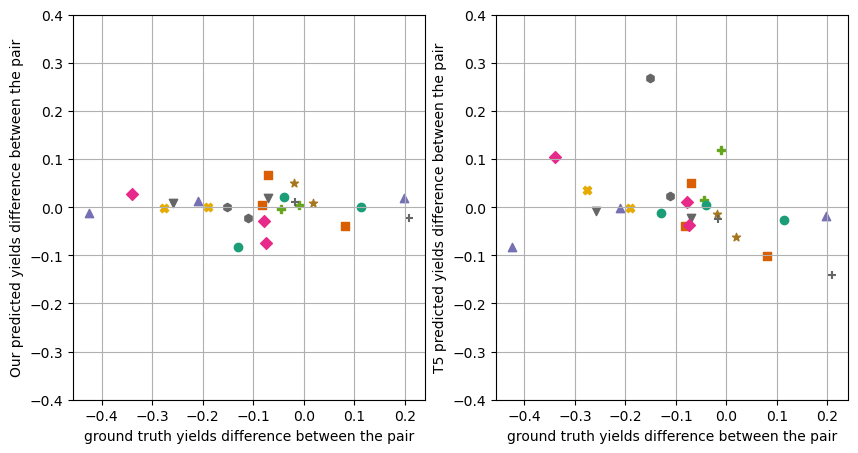

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10,5))
colormaps = plt.cm.Dark2  # You can choose any qualitative colormap
markers = ['o', 's', '^', 'D', 'P', 'X', '*', '+', 'v', 'h']
for i in range(len(target_diff)):
    axes[0].scatter(target_diff[i]/100,our_diff[i]/100,c=colormaps(i%10),marker = markers[i%10],alpha=1)
axes[0].grid('ON')
axes[0].set_xlabel('ground truth yields difference between the pair')
axes[0].set_ylabel('Our predicted yields difference between the pair')
axes[0].set_ylim((-0.4,0.4))
fig2 = plt.figure()
for i in range(len(target_diff)):
    #plt.scatter(target_diff[i],our_diff[i],c='green',marker='o',alpha=0.5)
    axes[1].scatter(target_diff[i]/100,t5_diff[i]/100,c=colormaps(i%10),marker = markers[i%10],alpha=1)
axes[1].grid('ON')
axes[1].set_xlabel('ground truth yields difference between the pair')
axes[1].set_ylabel('T5 predicted yields difference between the pair')
axes[1].set_ylim((-0.4,0.4))
#plt.tight_layout()

112 109


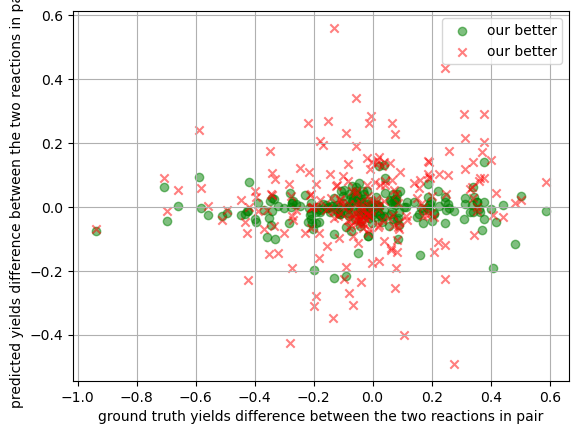

In [15]:
our_diff = np.array(our_diff)
t5_diff = np.array(t5_diff)
target_diff = np.array(target_diff)
index = np.where(abs(target_diff - our_diff) < abs(target_diff - t5_diff))[0]
index2 = np.where(abs(target_diff - our_diff) > abs(target_diff - t5_diff))[0]
print(len(index),len(index2))
#plt.scatter(target_diff[index]/100,our_diff[index]/100,c='green',marker='o',alpha=0.5,label='our better') 
plt.scatter(target_diff/100, our_diff/100,c='green',marker='o',alpha=0.5,label='our better')     
plt.scatter(target_diff/100, t5_diff/100,c='red',marker='x',alpha=0.5,label='our better')      
#plt.scatter(target_diff[index2]/100,t5_diff[index2]/100,c='red',marker='x',alpha=0.5,label='t5 better')
#plt.xlim((-0.7,1))
#plt.ylim((-0.4,0.4))
plt.legend()
plt.xlabel('ground truth yields difference between the two reactions in pair')
plt.ylabel('predicted yields difference between the two reactions in pair')
#plt.legend(['our better', 't5 better'])

plt.grid('on')


(array([26., 39., 13., 10., 11.,  2.,  4.,  2.,  1.,  1.]),
 array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <BarContainer object of 10 artists>)

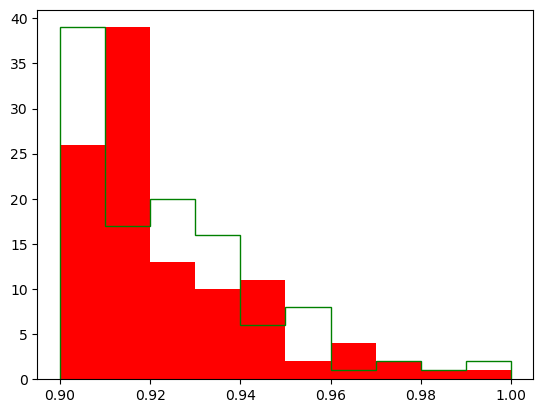

In [16]:
plt.hist(np.array(sim)[index],histtype='step',color='green')
plt.hist(np.array(sim)[index2],color='red')

In [9]:
t1 = abs(target_diff - our_diff)
t2 = abs(target_diff - t5_diff) 
res_our = stats.pearsonr(t1-t2, sim)
print(res_our)


PearsonRResult(statistic=-0.0918702692402837, pvalue=0.17355021436873988)


66.7 69.3092269897461 73.01541900634766


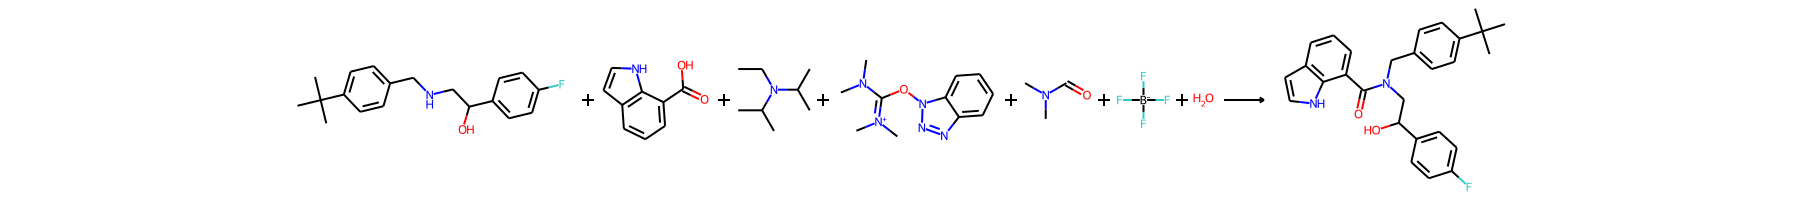

In [40]:

import pandas as pd
import argparse
#import cairosvg
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions

data = pd.read_csv('threshold0.9.csv')
index = [34,35]
smiles0 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles1 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn0 = Reactions.ReactionFromSmarts(smiles0, useSmiles=True)
print(data['t'].values[index[0]], data['t5'].values[index[0]], data['our'].values[index[0]])
Draw.ReactionToImage(rxn0, useSVG=False, drawOptions=None, returnPNG=False)

#Draw.MolToFile(mol, fname+"png", fitImage=False, imageType='png')

51.0 68.4637451171875 64.30867004394531


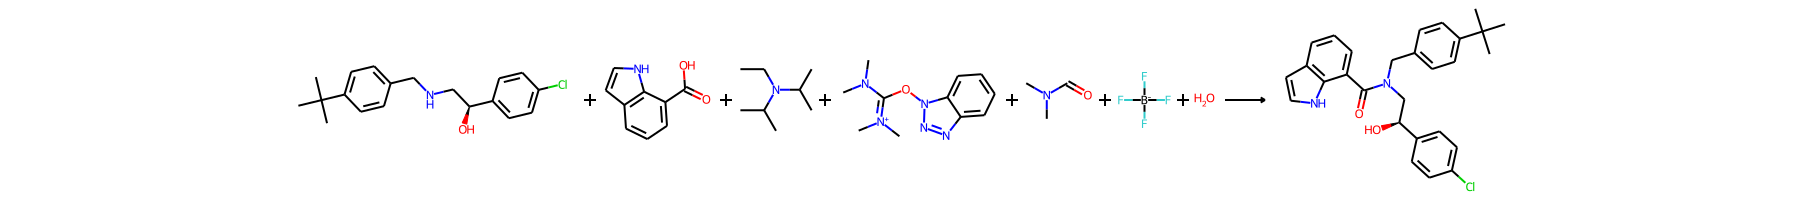

In [41]:
rxn1 = Reactions.ReactionFromSmarts(smiles1, useSmiles=True)
print(data['t'].values[index[1]], data['t5'].values[index[1]], data['our'].values[index[1]])
Draw.ReactionToImage(rxn1)

53.90000000000001 43.979454040527344 53.92887115478516


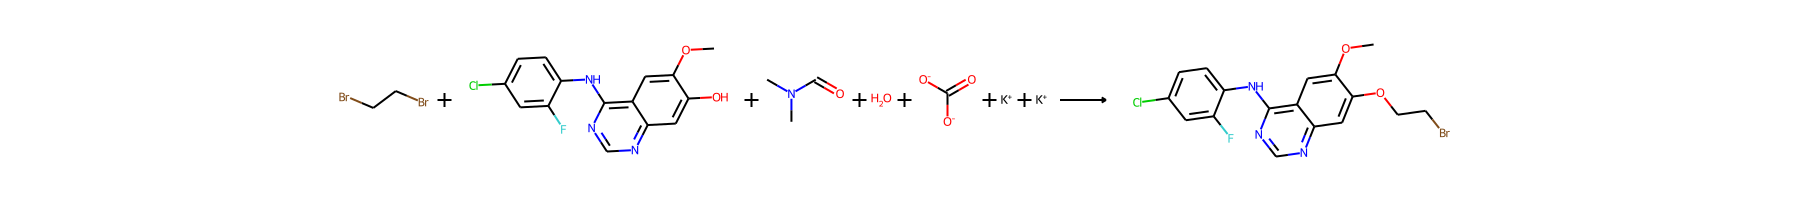

In [42]:
index = [148,149]
smiles2 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles3 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn2 = Reactions.ReactionFromSmarts(smiles2, useSmiles=True)
print(data['t'].values[index[0]], data['t5'].values[index[0]], data['our'].values[index[0]])
Draw.ReactionToImage(rxn2)

52.2 36.00663375854492 53.27740478515625


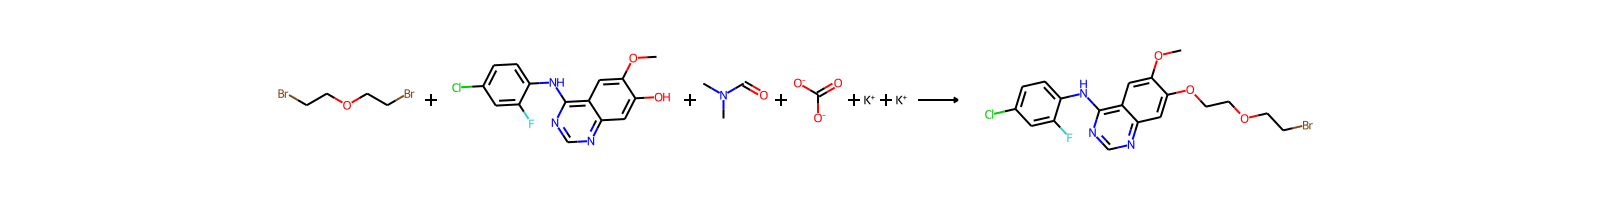

In [43]:
rxn3 = Reactions.ReactionFromSmarts(smiles3, useSmiles=True)
print(data['t'].values[index[1]], data['t5'].values[index[1]], data['our'].values[index[1]])
Draw.ReactionToImage(rxn3)

78.2 77.96569061279297 70.9262924194336


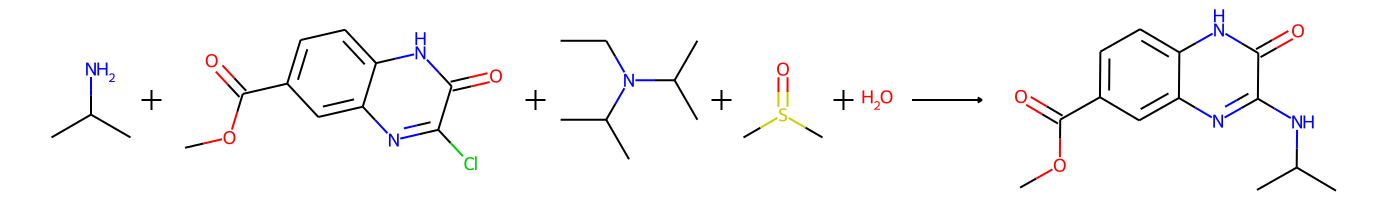

In [44]:
index = [190,191]
smiles4 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles5 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn4 = Reactions.ReactionFromSmarts(smiles4, useSmiles=True)
print(data['t'].values[index[0]], data['t5'].values[index[0]], data['our'].values[index[0]])
Draw.ReactionToImage(rxn4)

64.9 43.31938934326172 62.844200134277344


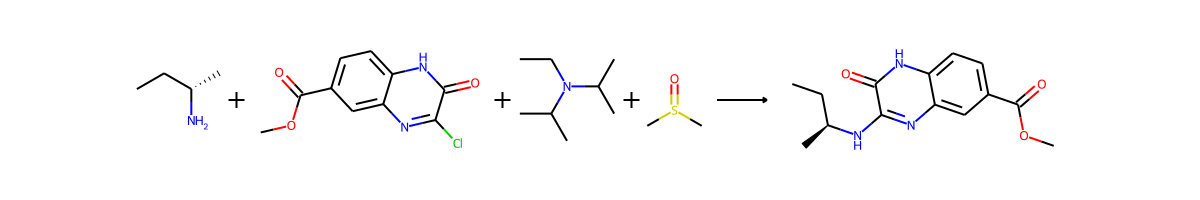

In [45]:

rxn5 = Reactions.ReactionFromSmarts(smiles5, useSmiles=True)
print(data['t'].values[index[1]], data['t5'].values[index[1]], data['our'].values[index[1]])
Draw.ReactionToImage(rxn5)

68.5 31.354097366333008 48.06367492675781


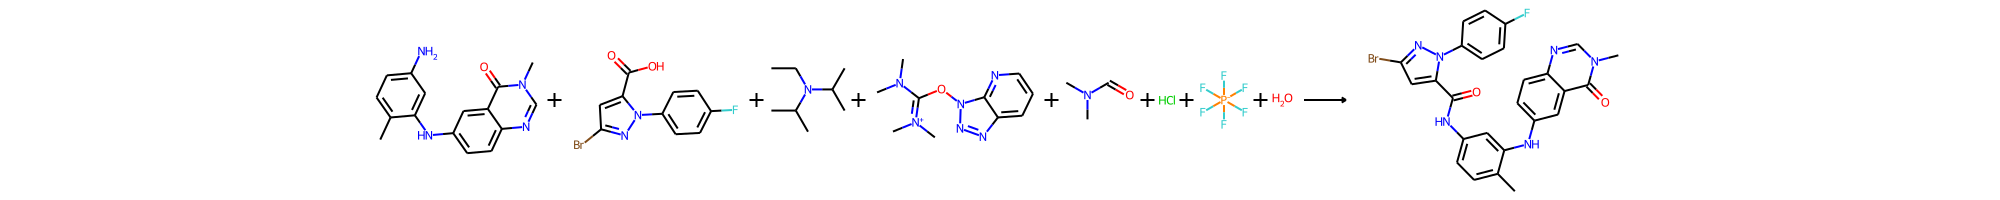

In [52]:
index = [122,123]
smiles6 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles7 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn6 = Reactions.ReactionFromSmarts(smiles6, useSmiles=True)
print(data['t'].values[index[0]], data['t5'].values[index[0]], data['our'].values[index[0]])
Draw.ReactionToImage(rxn6)

55.50000000000001 87.44007873535156 38.255157470703125


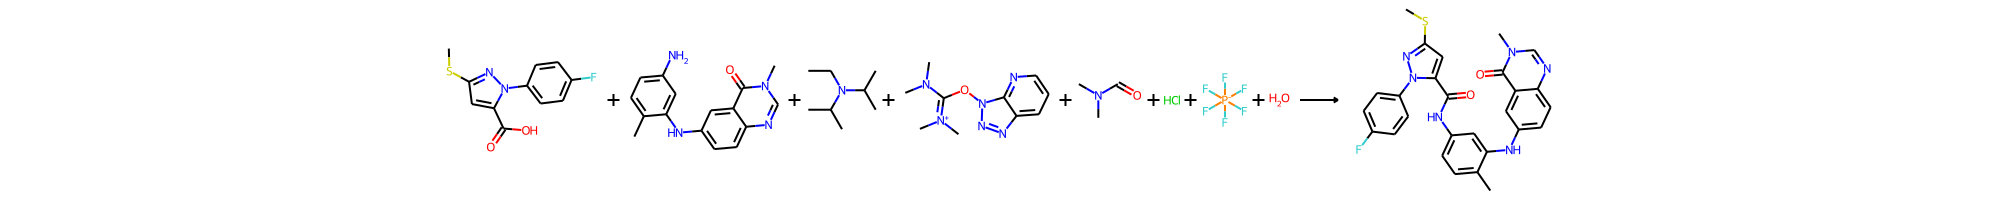

In [53]:
rxn7 = Reactions.ReactionFromSmarts(smiles7, useSmiles=True)
print(data['t'].values[index[1]], data['t5'].values[index[1]], data['our'].values[index[1]])
Draw.ReactionToImage(rxn7)

In [8]:
target_diff = []
t5_diff = []
t5_err = []
our_diff = []
our_err = []
for i in range(len(pairs)):
    index1 = pairs[i][0]
    index2 = pairs[i][1]
    t5_err.append(np.abs(t5pred[index1]-t5target[index1]))
    t5_err.append(np.abs(t5pred[index2]-t5target[index2]))
    our_err.append(np.abs(ourpred[index1]-t5target[index1]))
    our_err.append(np.abs(ourpred[index2]-t5target[index2]))

    target_diff.append(t5target[index1] - t5target[index2])
    t5_diff.append(t5pred[index1] - t5pred[index2])
    our_diff.append(ourpred[index1] - ourpred[index2])

In [9]:
print(np.mean(np.array(our_err)))
print(np.mean(np.array(t5_err)))


0.17455842449862455
0.1848020758361126


In [11]:
print(target_diff[:100])

[0.4470000076293945, 0.94, 0.8799999999999999, -0.06000000000000005, -0.355, 0.08999999999999997, 0.05900001525878906, -0.07099998474121094, -0.5179999923706055, -0.7819999980926514, -0.8719999980926514, 0.06599998474121094, 0.4209999847412109, -0.39099998474121095, -0.4809999847412109, 0.3910000133514404, -0.5180000114440918, -0.22199996948242184, -0.3119999694824218, 0.1690000152587891, 0.31999999999999995, -0.22199996948242184, 0.07999999999999996, -0.585, -0.06700000762939451, 0.024000015258789142, 0.245999984741211, 0.8899999999999999, -0.050000000000000044, 0.010000000000000009, -0.6920000171661377, -0.3370000171661377, -0.7580000019073486, 0.4369999885559081, -0.14700004577636716, 0.27, 0.12000003814697269, -0.3269999694824218, 0.19100002288818363, 0.25800003051757814, -0.3090000152587892, 0.2609999847412109, 0.7789999961853027, 0.23799995422363296, -0.32099998474121094, -0.0990000152587891, -0.3450000000000001, -0.15000000000000002, -0.24, 0.6319999980926514, 0.2409999847412109

CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CC(C)(CNCCN(CCCCCN1C(=O)c2ccccc2C1=O)CC(C)(C)SC(c1ccccc1)(c1ccccc1)c1ccccc1)SC(c1ccccc1)(c1ccccc1)c1ccccc1
CC#N.ClCCl.O=C([O-])[O-].[K+].[K+]
CC(C)(C)OC(=O)N(CCN(CCCCCN1C(=O)c2ccccc2C1=O)CC(C)(C)SC(c1ccccc1)(c1ccccc1)c1ccccc1)CC(C)(C)SC(c1ccccc1)(c1ccccc1)c1ccccc1
99.1 32
80.76195 46.64288330078125


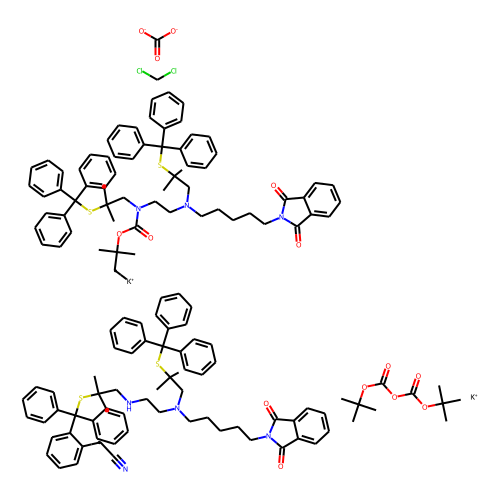

In [19]:

from rdkit.Chem import Draw
intersect_index = [2593, 6854, 166, 9161, 1739, 5707, 6670, 9265, 5718, 7643, 92, 5181, 4766]
i = 10
r_i = data['reactants'].values[intersect_index[i]]
a_i = data['reagents'].values[intersect_index[i]]
p_i = data['products'].values[intersect_index[i]]
reaction = r_i + "->" + a_i + '->' + p_i
m = Chem.MolFromSmiles(reaction)
print(r_i)
print(a_i)
print(p_i)
print(data['yield'].values[intersect_index[i]], data['label'].values[intersect_index[i]])
print(ourpred[intersect_index[i]], t5pred[intersect_index[i]])
img = Draw.MolsToImage([m], molsPerRow=10, subImgSize=(500,500), returnPNG=False)
img

In [110]:

data_i = sep_data[np.where(label_unique==476)[0][0]]
index = np.where(data_i['reagents'] == 'CC(=O)O.O=C([O-])O.[Na+]')[0]
print(index, data_i['yield'].values[index[0]])

[6] 35.2


In [20]:
df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/t5chem/models/uspto500mt/predictions.csv')
t5target = df1['target'].values
t5pred = df1['prediction'].values

ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto/womodels/result.pt',map_location=torch.device('cpu'))[:,0]) * 100
#label = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/preprocessed_datasets/USPTO/USPTO500MT_test_processed_100.csv')['label'].values
data = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/preprocessed_datasets/USPTO/USPTO500MT_test_processed_100.csv')
data_ori = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/preprocessed_datasets/USPTO/test.csv')
label_unique = data['label'].unique()
temp = []
sep_data = []

for i in label_unique:
    sep_data.append(data[data["label"] == i])
    template = data_ori[data_ori['labels']==i]['retro_template'].values[0]
    print(template)
    temp.append(template)


([C:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])>>([C:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4])
([C:4]-[N;H0;D3;+0:5](-[C:6])-[c;H0;D3;+0:1](:[c:2]):[c:3])>>(Br-[c;H0;D3;+0:1](:[c:2]):[c:3]).([C:4]-[NH;D2;+0:5]-[C:6])
([C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](=[O;D1;H0:2])(=[O;D1;H0:3])-[c:4])>>(Cl-[S;H0;D4;+0:1](=[O;D1;H0:2])(=[O;D1;H0:3])-[c:4]).([C:5]-[OH;D1;+0:6])
([C:2]-[C;H0;D3;+0:1](-[c:3])=[N;H0;D2;+0:4]-[O;D1;H1:5])>>(O=[C;H0;D3;+0:1](-[C:2])-[c:3]).([NH2;D1;+0:4]-[O;D1;H1:5])
([C:4]-[N;H0;D3;+0:5](-[C:6])-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3])>>(O-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3]).([C:4]-[NH;D2;+0:5]-[C:6])
([C:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3])>>([C:1]-[CH2;D2;+0:2]-[OH;D1;+0:3])
([#7;a:4]:[c:3]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[NH;D2;+0:6]-[C:5])>>(O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]:[#7;a:4]).([C:5]-[NH2;D1;+0:6])
([C:4]-[O;H0;D2;+0:5]-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3])>>(C-C(=O)-O-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3]).([C:4]-[OH;D1;+0:5])
([C:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:3]-[c:4]

In [21]:
judge = 'reactants'
for i in range(len(label_unique)):
    label = label_unique[i]
    temp_data = sep_data[i]
    l = sep_data[i].shape[0]
    r_unique, r_unique_count = np.unique(temp_data[judge].values, return_counts=True)
    if len(r_unique) < l:
        print('%d template, has %d reactions, %d reactants are unique'%(label, l, len(r_unique)))
        r_select = r_unique[np.where(r_unique_count>=2)[0]]
        for k in r_select:
            index1 = np.where(data['label'].values==label)[0]
            index2 = np.where(temp_data[judge].values==k)[0]

            target = t5target[index1][index2]
            t5 = t5pred[index1][index2]
            our = ourpred[index1][index2]

            
            print(temp_data['reactants'].values[index2], temp_data['reagents'].values[index2], temp_data['products'].values[index2],)


    

34 template, has 78 reactions, 75 reactants are unique
['COCCOCCO.Cc1ccc(S(=O)(=O)Cl)cc1' 'COCCOCCO.Cc1ccc(S(=O)(=O)Cl)cc1'] ['C1CCOC1.O.[Na+].[OH-]' 'O.c1ccncc1'] ['COCCOCCOS(=O)(=O)c1ccc(C)cc1' 'COCCOCCOS(=O)(=O)c1ccc(C)cc1']
['Cc1ccc(S(=O)(=O)Cl)cc1.OCC1CCOC1' 'Cc1ccc(S(=O)(=O)Cl)cc1.OCC1CCOC1'] ['C1CCOC1.CCN(CC)CC' 'ClCCl.O.c1ccncc1'] ['Cc1ccc(S(=O)(=O)OCC2CCOC2)cc1' 'Cc1ccc(S(=O)(=O)OCC2CCOC2)cc1']
['Cc1ccc(S(=O)(=O)Cl)cc1.OCC1COc2ccccc2O1'
 'Cc1ccc(S(=O)(=O)Cl)cc1.OCC1COc2ccccc2O1'] ['CCN(CC)CC.ClCCl' 'Cl.c1ccncc1'] ['Cc1ccc(S(=O)(=O)OCC2COc3ccccc3O2)cc1'
 'Cc1ccc(S(=O)(=O)OCC2COc3ccccc3O2)cc1']
25 template, has 73 reactions, 72 reactants are unique
['CN(CCO)C(=O)OC(C)(C)C' 'CN(CCO)C(=O)OC(C)(C)C'] ['CC(=O)OI1(OC(C)=O)(OC(C)=O)OC(=O)c2ccccc21.ClCCl.O=C([O-])O.O=S([O-])([O-])=S.[Na+].[Na+].[Na+]'
 'CCN(CC)CC.CO.CS(C)=O.ClCCl.O=S(=O)=O.c1ccncc1'] ['CN(CC=O)C(=O)OC(C)(C)C' 'CN(CC=O)C(=O)OC(C)(C)C']
108 template, has 34 reactions, 33 reactants are unique
['CN.O=C(O)c1ccc(Br)cn1' 'CN.

In [ ]:
x = [0.75, 0.80, 0.85, 0.9, 0.95]
y = [3029]